In [1]:
from PIL import Image                                   
from time import time                                      # various time-related functions
import os                                                  # portable way of using operating system dependent functionality
import numpy as np                                         # contains multidimensional array and matrix data structures
import matplotlib.pyplot as plt                            # data visualization library for plots, graphs and charts
%matplotlib inline
import cv2   

In [2]:
from pynq_dpu import DpuOverlay
from pynq_peripherals import PmodGroveAdapter
overlay = DpuOverlay("dpu.bit")

In [3]:
overlay.load_model("FADNet_pruned_1_pt.xmodel")

# creates a runner instance that has a number of member functions to control 
# the execution and get the input and output tensors
dpu = overlay.runner

# define the required input and output shapes of the data being put into and received from the model
inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)



In [4]:
shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
print("Shape in: " + str(shapeIn))
print("Shape out: " + str(shapeOut))

Shape in: (1, 576, 960, 3)
Shape out: (1, 72, 120, 256)


In [5]:

# Setup Buffers
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
image = input_data[0]

In [6]:
INPUT_HEIGHT = 576
INPUT_WIDTH = 960

In [7]:
# Function to perform pre-processing, model predictions and decoding output
def run(frame, display=False):
    
    # Pre-processing
    image_size = frame.shape[:2]
    image_data = np.array(pre_process(frame, (INPUT_HEIGHT, INPUT_WIDTH)), dtype=np.float32)
    #cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB) 
    
    # Fetch data to DPU and trigger it
    image[0,...] = image_data.reshape(shapeIn[1:])
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    
    if display: print(output_data)
    
    return output_data
        

def letterbox_image(image, size):
    ih, iw, _ = image.shape
    w, h = size
    scale = min(w/iw, h/ih)
    
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = cv2.resize(image, (nw,nh), interpolation=cv2.INTER_LINEAR)
    new_image = np.ones((h,w,3), np.uint8) * 128
    h_start = (h-nh)//2
    w_start = (w-nw)//2
    new_image[h_start:h_start+nh, w_start:w_start+nw, :] = image
    return new_image

def pre_process(image, model_image_size):
    image = image[...,::-1]
    image_h, image_w, _ = image.shape
 
    if model_image_size != (None, None):
        assert model_image_size[0]%32 == 0, 'Multiples of 32 required'
        assert model_image_size[1]%32 == 0, 'Multiples of 32 required'
        boxed_image = letterbox_image(image, tuple(reversed(model_image_size)))
    else:
        new_image_size = (image_w - (image_w % 32), image_h - (image_h % 32))
        boxed_image = letterbox_image(image, new_image_size)
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0) 
    return image_data

Capture device is open: True


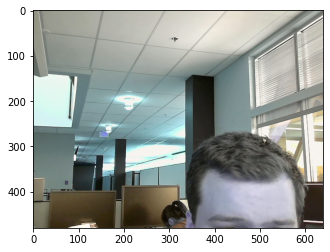

In [9]:
# Start capturing a video 
videoIn = cv2.VideoCapture(0)
videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, 640);
videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, 480);

print("Capture device is open: " + str(videoIn.isOpened()))
_, frame = videoIn.read()
plt.imshow(frame)
videoIn.release()  

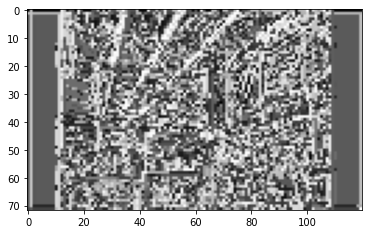

In [16]:
output = run(frame, display=False)
classMap_numpy = np.argmax(output, axis=-1).astype(np.uint8)
photo_array = np.empty((72,120,3), dtype=np.int32, order="C")

for h in range(0, len(classMap_numpy[0][0])): #for all lines
    for w in range(0, len(classMap_numpy[0][0][h])): #for all columns
        pixel =  classMap_numpy[0][0][h][w]
        photo_array[h][w][:] = pixel
        
#print(photo_array[0])
plt.imshow(photo_array)

In [18]:
print(output[0][0][0][0])
print(photo_array[0][0])

[0.    0.    0.875 0.    0.    0.    0.    0.    0.    0.    2.875 0.
 5.    1.625 0.    0.375 0.    0.    3.5   0.    0.    2.5   2.25  1.125
 0.    0.625 0.    0.    0.    2.25  4.875 0.    1.375 0.875 0.    0.
 0.625 0.    1.25  0.    2.    0.    1.25  1.    0.    0.    0.    0.5
 0.    0.    3.    0.    0.    0.    1.375 0.75  0.    0.    0.    3.125
 0.    3.375 0.    0.    0.    0.    0.    2.    0.    0.    1.    0.
 0.125 2.375 0.    0.    1.5   0.25  1.375 2.125 0.    0.    0.    0.
 2.375 0.    2.5   0.    0.    0.    1.625 0.    3.625 0.    1.25  0.
 0.    0.    3.25  0.    0.    0.5   0.    0.75  0.    1.625 0.875 0.
 4.5   3.375 0.75  0.    0.    3.25  0.    0.    0.375 2.875 0.    0.25
 0.    0.    0.    0.    3.25  0.    0.    0.    3.375 0.5   0.    3.5
 3.625 0.75  0.    1.25  0.    0.    0.    2.125 2.5   0.    1.5   2.875
 3.75  0.    0.    0.    0.    0.    1.375 0.    1.125 3.25  0.    0.
 0.5   0.    0.    0.    0.    0.25  0.25  0.    0.    0.    0.    0.
 2.875 

In [ ]:
# Start capturing a video 
videoIn = cv2.VideoCapture(0)
videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, 640);
videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, 480);

print("Capture device is open: " + str(videoIn.isOpened()))

In [ ]:
for _ in range(200):
    _, frame = videoIn.read()
    output = run(frame, display=False)
    photo_array = np.empty((144,240,3), dtype=np.int32, order="C")

    for h in range(0, len(classMap_numpy[0][0])): #for all lines
        for w in range(0, len(classMap_numpy[0][0][h])): #for all columns
            pixel =  classMap_numpy[0][0][h][w]
            photo_array[h][w][:] = pixel
        
    #print(photo_array[0])
    plt.imshow(photo_array, vmin=0,vmax=128)
    

In [ ]:
videoIn.release()  